In [1]:
import os
import glob
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('font', family='serif')

%matplotlib inline
from scipy.interpolate import *

# select the M11-library and IMF type for the models to be used
models_used = 'ELODIE'
imf_used = 'cha'

In [2]:
wvgem09, flgem09=np.loadtxt('gemini09.txt', unpack=True)
flgem09_sm=convolve(flgem09, Box1DKernel(11))
wvkeck, flkeck=np.loadtxt('keck.txt', unpack=True)
wvgem11, flgem11=np.loadtxt('gemini11.txt', unpack=True)
gem11_sm = convolve(flgem11, Box1DKernel(11))
wvsr1614, flsr1614=np.loadtxt('rz2109/soar_20160314.txt', unpack=True)
flsr1614sm=convolve(flsr1614, Box1DKernel(11))
wvsr1814, flsr1814=np.loadtxt('rz2109/soar_20180314.txt', unpack=True)
flsr1814sm=convolve(flsr1814, Box1DKernel(11))
wvsr1815, flsr1815=np.loadtxt('rz2109/soar_20180315.txt', unpack=True)
flsr1815sm=convolve(flsr1815, Box1DKernel(11))

wvgem15, flgem15=np.loadtxt('gem15_0316.txt', unpack=True)

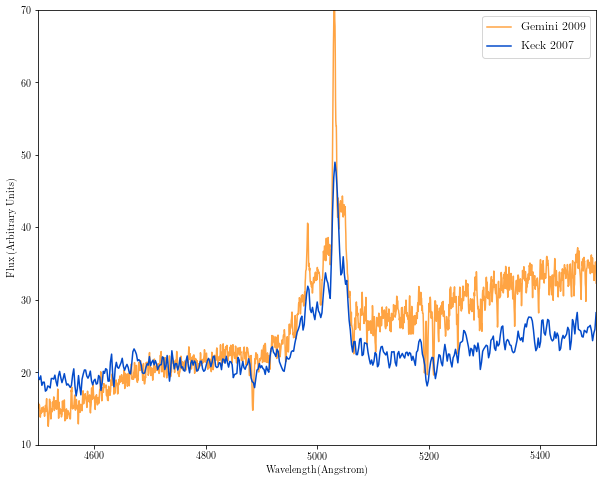

In [159]:
plt.figure(figsize=(10,8))
#plt.plot(wvgem11, flgem11*20, color=palettable.cubehelix.cubehelix3_16.mpl_colors[3], label='Gemini 2011', zorder=12, alpha=0.75)

plt.plot(wvgem09, flgem09/8., color=palettable.cubehelix.cubehelix3_16.mpl_colors[11], label='Gemini 2009')
plt.plot(wvkeck, flkeck*1.7e18, color=palettable.cubehelix.cubehelix3_16.mpl_colors[4], label='Keck 2007', zorder=10)
#plt.plot(wvsr1614, flsr1614/1.4, color=palettable.cubehelix.cubehelix3_16.mpl_colors[9], label='SOAR- 20160314', alpha=0.8, zorder=11)
#plt.plot(wvsr1814, flsr1814/1.2, color=palettable.cubehelix.cubehelix3_16.mpl_colors[6], label='SOAR- 20180314', alpha=0.5)
#plt.plot(wvsr1815, flsr1815/1.9, color=palettable.cubehelix.cubehelix3_16.mpl_colors[7], label='SOAR- 20180315')
plt.xlim(4500, 5500)
#plt.axvline(x=5030, color=palettable.cubehelix.cubehelix3_16.mpl_colors[2], lw=2)
#plt.axhline(y=18)
plt.ylim(10, 70)
plt.legend(loc=1,numpoints=1,fontsize=12)
plt.ylabel('Flux (Arbitrary Units)')
plt.xlabel('Wavelength(Angstrom)')

plt.savefig('oiiline.jpg')

In [4]:
mask_low=4964
mask_hi=5058

In [225]:
def fitslope(influx=flgem09, inwavelen=wvgem09, k_spacing=2, g_space=11):
    
    ##need to subtract or add 25 because I am going to take 50 angstrom wide blocks by considering x+25 and x-25.
    data_low=4500
    data_high=5500
    mask_low=4940-25
    mask_hi=5100+25
    
    dl=4500
    dh=5500
    range_1=np.where((wvkeck>data_low)&(wvkeck<mask_low))
    range_2=np.where((wvkeck>mask_hi)&(wvkeck<data_high))



    range_3=np.where((inwavelen>data_low)&(inwavelen<mask_low))
    range_4=np.where((inwavelen>mask_hi)&(inwavelen<data_high))
    
    data1=np.where((wvkeck>(dl))&(wvkeck<(dh)))
    data2=np.where((inwavelen>dl)&(inwavelen<dh))
    ###select 50 angstrom wide blocks
    
    ##I want to find the factor as a function of wavelength, so I will start at data_low and progress upwards.
    #let's do this every 5th element?
    
    
    x_low=wvkeck[range_1][::k_spacing]
    x_high=wvkeck[range_2][::k_spacing]
    
    
    
    y_low=inwavelen[range_3][::g_space]
    y_high=inwavelen[range_4][::g_space]
    
    
    
    f_low_k=movingavg(r=range_1, flux=flkeck, wav=x_low, inwav=wvkeck,space=k_spacing)
    f_low_unflux=movingavg(r=range_3, flux=influx, wav=y_low, inwav=inwavelen,space=k_spacing)

    
    f_high_k=movingavg(r=range_2, flux=flkeck, wav=x_high, inwav=wvkeck,space=g_space)
    f_high_unflux=movingavg(r=range_4, flux=influx, wav=y_high, inwav=inwavelen,space=g_space)
    
    plt.figure(1)
    plt.subplot(211)
    plt.title('Keck (above) and Gemini (below)')
    plt.ylabel('Flux')
    plt.plot(x_low, f_low_k)
    plt.plot(x_high, f_high_k)
    plt.subplot(212)
  
    plt.plot(y_low, f_low_unflux)
    plt.plot(y_high, f_high_unflux)
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.savefig('slope_comp1.jpg')
    
    
    print 'Keck spacing:', (x_low[1]-x_low[0]), 'Comp spacing:',(y_low[0]-y_low[1])
    
    ##need to join up high and low
    x_wav=np.concatenate((x_low, x_high))
    x_fl=np.concatenate((f_low_k, f_high_k))
    
    y_wav=np.concatenate((y_low,y_high))
    y_fl=np.concatenate((f_low_unflux, f_high_unflux))
    
    ##test this
    plt.figure(2)
    plt.subplot(211)
    plt.title('Keck (above) and Gemini (below)')
    plt.ylabel('Flux')
    plt.plot(x_wav, x_fl)
    plt.plot(x_high, f_high_k)
    plt.subplot(212)
    plt.plot(y_wav, y_fl)
    plt.plot(y_high, f_high_unflux)
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.savefig('slope_comp2.jpg')
    
    ###want fitted keck flux and fitted other flux to have same dimensions so ultimately can just divide
    #what happens if I plug other wavelength into keck fit so they have the same sampling?
    #it worked!
    
    xwvfit, xflfit=fitpoly(x_wav, x_fl,inwavelen[data2])
    ywvfit, yflfit=fitpoly(y_wav,y_fl,inwavelen[data2])
    

    plt.figure(3)
    plt.subplot(211)
    plt.title('Keck (above) and Gemini (below)')
    plt.ylabel('Flux')
    plt.plot(xwvfit, xflfit, '--')
    plt.plot(x_wav, x_fl)

    #plt.plot(x_high, f_high_k)
    plt.subplot(212)
  
    plt.plot(ywvfit, yflfit, '--')
    plt.plot(y_wav, y_fl)

   # plt.plot(y_high, f_high_unflux)
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.savefig('slope_comp3.jpg')
    
    
    
    
    slopefac=xflfit/yflfit
    return slopefac

In [196]:
def movingavg(r, flux, wav, inwav, space):
    
    fl=[]
    for i in range(len(wav)):

        g_ind=np.where(inwav==wav[i])

        g_low=np.int(g_ind[0])-25
        g_high=np.int(g_ind[0])+25

        
        f=np.average(flux[g_low:g_high])
        
        if np.size(fl)<1:
            fl=f
        else:
            fl=np.vstack((fl,f))
            
    
    return fl

In [208]:
def fitpoly(x,y,fullwav):
   

    c = np.polyfit(x, y, 5)
    c = np.squeeze(c)
    p5 = np.poly1d(c)
    ynew=p5(fullwav)
    
    return fullwav, ynew


Keck spacing: 4.23572744015 Comp spacing: -5.20031741937


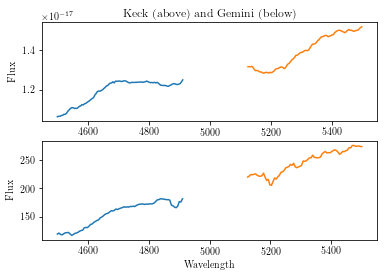

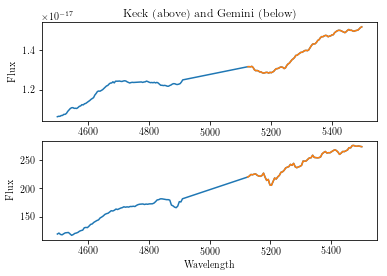

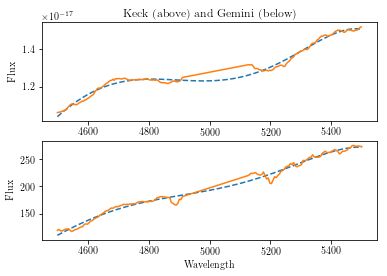

In [224]:
fitslope()

601